In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np          # numerical python - mathematical and logical operations on arrays
import pandas as pd                         # works with the tabular data
import matplotlib.pyplot as plt              # plots, graphs and charts.

from keras.layers import Flatten, Dense                                           # Keras is a high-level neural network library, importing flatten and dense layers
from keras.models import Model                                                           # define model
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img              # apply random transformations , converts img to numpy array , loads image
from keras.applications.mobilenet import MobileNet, preprocess_input                      # Efficient Conv NN for Mobile Vision Applications scale input pixels between -1 and 1.
from keras.losses import categorical_crossentropy                                  # calculate loss. it is loss function for multi-class classification model
# from sklearn.metrics import f1_score
# from sklearn.metrics import cohen_kappa_score
# from sklearn.metrics import roc_auc_score
import keras.backend as K
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier



from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers.core import Dense, Dropout, Activation, Flatten

def f1_score(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Working with pre trained model

base_model =  MobileNet( input_shape=(224,224,3), include_top= False )        #  include_top = false is allowing new o/p layer to be added and trained
for layer in base_model.layers:
  layer.trainable = False                      # moves all layer's weights from trainable to non-trainable.freezing the layer, indicating that this layer should not be trained.


z = Flatten()(base_model.output)
x = Dense(units=11 , activation='softmax' )(z)           # unit is o/p dimension , softmax-vector of values to a probability distribution(fr last layer) [p(happily sad)]

# creating our model.
model = Model(base_model.input, x)




17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
print(z.shape)

(None, 50176)


In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss= categorical_crossentropy , metrics=['accuracy','AUC','Recall','Precision',f1_score])

          # optimizer-updates acc to loss [changes step ] [adam-adaptive moment estimation]
          # loss=CC - prob distribution. it is designed to quantify the difference between two probability distributions.
          # metrics-acc - check performance
          # AUC - Area under the curve, analyze the prediction more deeply.
          # Recall - how many of the true positives were recalled (found), i.e. how many of the correct hits were also found
          # Precision -the quality of a positive prediction made by the model
          # get_f1 - F1 Score becomes 1 only when precision and recall are both 1.better measure than accuracy.


In [ ]:
train_datagen = ImageDataGenerator(
     zoom_range = 0.2,
     shear_range = 0.2,
     horizontal_flip=True,                     #slants the shape of image
     rescale = 1./255
)
val_datagen = ImageDataGenerator(
     zoom_range = 0.2,
     shear_range = 0.2,
     horizontal_flip=True,                     #slants the shape of image
     rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory= "/content/drive/MyDrive/dataset/train",
                                               target_size=(224,224),
                                               batch_size=20,                                      #divide dataset into Number of Batches
                                  )

val_data = val_datagen.flow_from_directory(directory= "/content/drive/MyDrive/dataset/test",
                                               target_size=(224,224),
                                               batch_size=20,                                      #divide dataset into Number of Batches
                                  )
train_data.class_indices

Found 3164 images belonging to 11 classes.
Found 725 images belonging to 11 classes.


{'1': 0,
 '10': 1,
 '11': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}

In [ ]:
## having early stopping and model check point
# A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

from keras.callbacks import ModelCheckpoint, EarlyStopping



# early stopping
es = EarlyStopping(monitor='val_accuracy',
                   min_delta= 0.0001 ,                   # an absolute change of less than min_delta, will count as no improvement.
                   patience= 7,                # Number of epochs with no improvement after which training will be stopped.
                   verbose= 1,                     # Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
                   mode='max')               # decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity.


# model check point
mc = ModelCheckpoint(filepath="/content/drive/MyDrive/dataset/best_model.h5",
                     monitor= 'val_accuracy',
                     verbose= 1,
                     save_best_only= True,
                     mode = 'max')

# puting call back in a list
#callbacks = [ModelCheckpoint("/content/drive/MyDrive/dataset/best_model.h5", save_best_only=True)]
call_back = [es, mc]

In [ ]:
#@title
hist = model.fit(train_data,

                           epochs= 20,
                           validation_data= val_data,
                           validation_steps= 1,
                           callbacks=[es,mc])

Epoch 1/20
159/159 [==============================] - ETA: 0s - loss: 10.2132 - accuracy: 0.3138 - auc: 0.6841 - recall: 0.3113 - precision: 0.3179 - f1_score: 0.3137 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/dataset/best_model.h5
159/159 [==============================] - 1863s 12s/step - loss: 10.2132 - accuracy: 0.3138 - auc: 0.6841 - recall: 0.3113 - precision: 0.3179 - f1_score: 0.3137 - val_loss: 4.8924 - val_accuracy: 0.5000 - val_auc: 0.8121 - val_recall: 0.4500 - val_precision: 0.4737 - val_f1_score: 0.4615
Epoch 2/20
159/159 [==============================] - ETA: 0s - loss: 6.4155 - accuracy: 0.4927 - auc: 0.7840 - recall: 0.4889 - precision: 0.4938 - f1_score: 0.4914
Epoch 2: val_accuracy did not improve from 0.50000
159/159 [==============================] - 62s 393ms/step - loss: 6.4155 - accuracy: 0.4927 - auc: 0.7840 - recall: 0.4889 - precision: 0.4938 - f1_score: 0.4914 - val_loss: 8.1402 - val_accuracy: 0.4000 - val_

In [ ]:
Y_pred = model.predict(val_data, 809)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix\n')
print(confusion_matrix(val_data.classes, y_pred))
print('\nClassification Report')
target_names = ['0', '1','2','3','4','5','6','7','8','9','10']
print(classification_report(val_data.classes, y_pred,target_names=target_names ))

Confusion Matrix

[[ 5 20  0  0  0  2  0 16  1  6  0]
 [22 55  1  1  0  7  0 49  2 39  0]
 [ 6 13  0  1  0  3  0 14  2  6  0]
 [ 8 19  0  0  0  4  0 11  0  7  1]
 [ 2  6  0  1  0  0  0  9  0  5  0]
 [ 0 11  0  1  2  1  0 13  0  5  0]
 [ 3  6  0  0  0  1  0  5  2  1  0]
 [15 45  0  0  3 12  0 33  0 29  4]
 [ 2 10  0  0  0  1  0 10  1 10  0]
 [17 38  2  1  2  4  0 36  1 16  0]
 [ 4 17  0  0  0  0  0  9  1  7  0]]

Classification Report
              precision    recall  f1-score   support

           0       0.06      0.10      0.07        50
           1       0.23      0.31      0.26       176
           2       0.00      0.00      0.00        45
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00        23
           5       0.03      0.03      0.03        33
           6       0.00      0.00      0.00        18
           7       0.16      0.23      0.19       141
           8       0.10      0.03      0.05        34
           9       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Loading the best fit model
from keras.models import load_model
my_custom_objects={'f1_score': f1_score}
model = load_model("/content/drive/MyDrive/dataset/best_model.h5", custom_objects= my_custom_objects)

In [ ]:
h =  hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'auc', 'recall', 'precision', 'f1_score', 'val_loss', 'val_accuracy', 'val_auc', 'val_recall', 'val_precision', 'val_f1_score'])

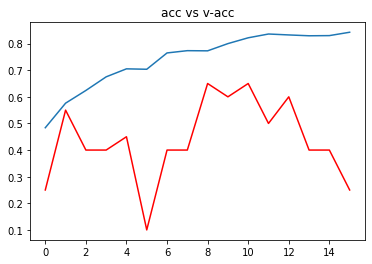

In [ ]:


plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c = "red")
plt.title("acc vs v-acc")
plt.show()

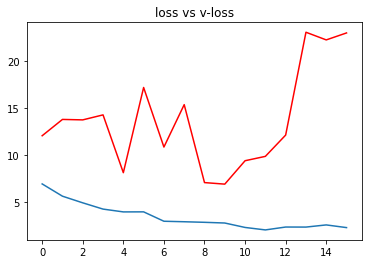

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

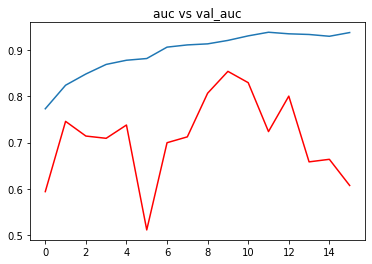

In [ ]:
plt.plot(h['auc'])
plt.plot(h['val_auc'] , c = "red")
plt.title("auc vs val_auc")
plt.show()

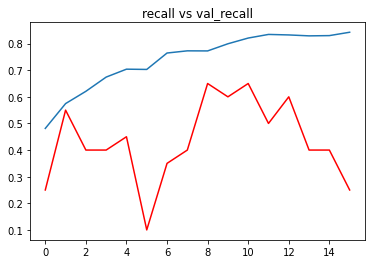

In [ ]:
plt.plot(h['recall'])
plt.plot(h['val_recall'] , c = "red")
plt.title("recall vs val_recall")
plt.show()

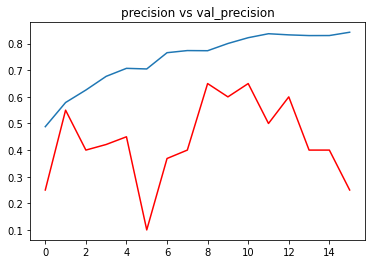

In [ ]:
plt.plot(h['precision'])
plt.plot(h['val_precision'] , c = "red")
plt.title("precision vs val_precision")
plt.show()

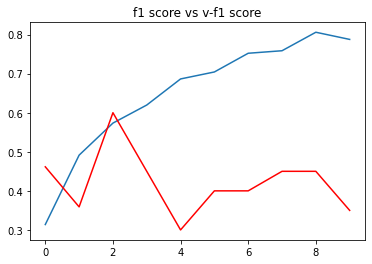

In [ ]:

plt.plot(h['f1_score'])
plt.plot(h['val_f1_score'],c = "red")
plt.title("f1 score vs v-f1 score")
plt.show()

In [ ]:
# just to map o/p values
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))


 # class_indices.keys() will extract the class names from the dataset in a dictionary
 # class_indices.values() will extract the class values from the dataset in a dictionary

 the image is of 10


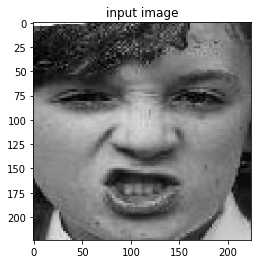

In [ ]:
# path for the image to see if it predics correct class

path = "/content/drive/MyDrive/dataset/test/10/test_007_aligned.jpg"
img = load_img(path, target_size=(224,224) )

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))              # argmax - Returns the index of the maximum value along an axis.

print(f" the image is of {op[pred]}")

# to display the image
plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

val [[1.0906476e-10 1.3857434e-30 1.5281599e-23 5.7890043e-34 1.2933098e-25
  1.8172311e-28 7.1124436e-29 3.8511116e-06 0.0000000e+00 9.9999619e-01
  8.2851910e-26]]
Angrily Disgusted


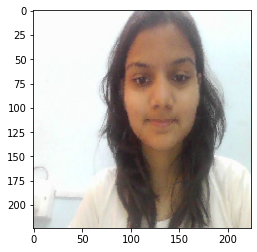

In [ ]:
img=load_img('/content/photo.jpg',target_size=(224,224,3))
plt.imshow(img)
X=img_to_array(img)
X=np.expand_dims(X,axis=0)
images=np.vstack([X])
val=model.predict(images)
print("val %s"%val)
rach=val.argmax()
if rach==0:
  print("Happily Surprised")
if rach==1:
  print("Happily Disgusted")
if rach==2:
  print(" Sadly Fearful")
if rach==3:
  print("Sadly Angry")
if rach==4:
  print(" Sadly Surprised")
if rach==5:
  print("Sadly Disgusted")
if rach==6:
  print(" Fearfully Angry")
if rach==7:
  print("Fearfully Surprised")
if rach==8:
  print("Angrily Surprised")
if rach==9:
  print("Angrily Disgusted")
if rach==10:
  print("Disgustedly Surprised")